Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><a style="font-size: 3em; text-align: center; vertical-align: middle;" href="https://moodle.polytechnique.fr/course/view.php?id=17527">[CSE204-2023] - Introduction to Machine Learning</a>
</td>
  </tr>
</table>

<a style="font-size: 3em;">Lab Session 7: Building a Neural Network From Scratch - Backpropagation</a>

J.B. Scoggins - Adrien Ehrhardt - Johannes Lutzeyer

This lab is a direct follow-up of Lab session #06 on Neural networks. We will now make the network trainable and... train it!

# Recall last lab's notations

We will consider simple feed-forward networks that can be described by the following recursive relationship,

$$
\begin{align}
&z^l = a^{l-1} W^l + b^l,\\
&a^l = \sigma^l(z^l),
\end{align}
$$

where $a^l$ is the output (activation) of layer $l$ which is a nonlinear function $\sigma^l$ of a linear transformation of the previous layer's output.  The linear transformation is performed using the weight matrix $W^l$ and bias vector $b^l$ associated with the layer $l$.  We will denote the last layer in the network with a capital $L$ superscript.  The recursion is stopped by setting $a^0 = x$, where $x$ is the input vector to our network.  Note that in the recursive expressions above, we implicitly assume that our input/output vectors are row vectors.  The reason for this will be evident later.

Taking this notation into account, we see that a network with $L-1$ hidden layers is fully expressed by its $L$ weight matrices, bias vectors, and activation functions.  We can denote the set of trainable parameters in our network by $\theta = \{ W^1, \dots, W^L, b^1, \dots, b^L \}$.

In this lab, we are only concerned with supervised learning tasks.  Recall that in supervised learning, we have a dataset represented by a list of $(x, y)$ pairs where $x$ is the input to our model and $y$ is the desired output.

- For regression problems where we want to fit a function $y = f(x)$, $x$ is the independent variable vector, and $y$ is the function value.
- In classification problems, $x$ will correspond to a set of attributes and $y$ the corresponding label.

The goal of supervised learning is to "train" our network by adjusting its parameters in order to minimize a cost function over the entire training set,

$$
\min_\theta \mathcal{L} = \min_\theta \sum_{i=1}^N \ell^{(i)}
$$

where $\ell^{(i)} = \ell(\sigma^L(\sigma^{L-1}(\dots(x^{(i)}W^1 + b^1)\dots)W^L + b^L), y^{(i)})$ and $\ell(\hat{y}, y)$ denotes the particular form of the loss function being considered.  In this lab, we will use 2 different loss functions:

1. Quadratic Loss: $\ell(\hat{y}, y) = \|\hat{y} - y\|^2$
2. Cross-entropy Loss: $\ell(\hat{y}, y) = -[ y \ln\hat{y} + (1-y)\ln(1-\hat{y})]$

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-04-10 23:36:23.017643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 23:36:23.017668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 23:36:23.018367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 23:36:23.022784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 23:36:23.999265: W tensorflow/compiler/tf2

Here are the activations classes you (hopefully) managed to implement last week:

In [2]:
class Activation(object):
    """
    Base activation node class
    """

    def __new__(self, x: np.array) -> np.array:
        """
        What to do when instantiating an object: this basically says Activation(x)
        will be equivalent to Activation()(x).

        :param numpy.array x: input of the activation
        :return: call the activation function
        :rtype: numpy.array
        """
        return self.__call__(x)

In [3]:
class Identity(Activation):
    """
    Identity activation node
    """

    @staticmethod
    def __call__(x: np.array) -> np.array:
        """
        Implements the identity activation function

        :param np.array x: input of the activation
        :return: identity of input
        :rtype: np.array
        """
        return x

    @staticmethod
    def prime(x: np.array) -> np.array:
        """
        Implements the derivative of the identity activation function

        :param numpy.array: input of the activation
        :return: derivative of input
        :rtype: numpy.array
        """
        return np.ones_like(x)

In [4]:
class Threshold(Activation):
    """
    Threshold activation node
    """

    @staticmethod
    def __call__(x: np.array) -> np.array:
        """
        Implements the threshold activation function

        :param numpy.array x: input of the activation
        :return: if x > 0, 1, else 0
        :rtype: numpy.array
        """
        return np.where(x > 0.0, 1.0, 0.0)

    @staticmethod
    def prime(x: np.array) -> np.array:
        """
        Implements the derivative of the threshold activation function

        :param numpy.array: input of the activation
        :return: derivative of input
        :rtype: numpy.array
        """
        return np.zeros_like(x)

In [5]:
class Sigmoid(Activation):
    """
    Sigmoid activation node
    """
    @staticmethod
    def __call__(x: np.array) -> np.array:
        """
        Implements the sigmoid activation function

        :param numpy.array x: input of the activation
        :return: sigmoid transform of input
        :rtype: numpy.array
        """
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def prime(x: np.array) -> np.array:
        """
        Implements the derivative of the sigmoid activation function
        (you can make good use of Sigmoid(...)!)

        :param numpy.array: input of the activation
        :return: derivative of input
        :rtype: numpy.array
        """
        sigmoid = Sigmoid(x)
        return sigmoid * (1.0 - sigmoid)

Here is the `Network` class you (hopefully) managed to implement last week.
**Notice that the implementation and signature of the `feed_forward` method changed so as not to recompute things in `back_propagation`** (see Question 1.3).

A `loss` attribute has also been added to record the evolution of the loss.

In [6]:
class Network:
    """
    A simple implementation of a feed-forward artificial neural network.
    Work on this class throughout the entire exercise, rerunning this cell after each update.
    """

    def __init__(self, sizes: list, activations: list):
        """
        Construct a network given a list of the number of neurons in each layer and
        a list of activations which will be applied to each layer.

        :param list sizes: A list of integers representing the number of nodes in each layer,
        including the input and output layers.
        :param list activations: A list of callable objects representing the activation functions.
        Its size should be one less than sizes.
        """
        self.sizes = sizes
        self.sigmas = activations
        self.loss = []

        self.biases = [np.random.randn(1, n) for n in sizes[1:]]
        self.weights = [
            np.random.randn(m, n) for m, n in zip(sizes[:-1], sizes[1:])
        ]
        # Optional: better initialization
        # self.weights = [
        #     np.random.randn(m, n) / np.sqrt(m) for m, n in zip(sizes[:-1], sizes[1:])
        # ]

    def num_params(self) -> int:
        """Returns the total number of trainable parameters in this network."""
        return sum([m * n + n for m, n in zip(self.sizes[:-1], self.sizes[1:])])

    def feed_forward(self, x: np.array):
        """
        Evaluates the network for the given input and returns the intermediary results.

        :param numpy.array x: A numpy 2D-array where the columns represent input variables
        and rows represent independent samples.
        :return: output of the network
        :rtype: np.array, list, list
        """
        activations = [x]
        zs = []

        # Forward pass, storing z and a as we go
        for W, b, sigma in zip(self.weights, self.biases, self.sigmas):
            zs.append(np.matmul(activations[-1], W) + b)
            activations.append(sigma(zs[-1]))
        return activations[-1], activations, zs

    def back_propagation(self, x: np.array, y: np.array, cost, verbose: bool = False):
        """
        Compute gradients of cost function w.r.t network parameters for a single training point.

        :param numpy.array x: a single input in a 2D array (1, #features), or possibly
            several inputs in a 2D array (#samples, #features)
        :param numpy.array y: a single output
        :param Cost cost: a cost class
        :param bool verbose: whether to print debugging information (you don't have to implement this feature)
        :return: list of gradients of weights, list of gradients of biases
        :rtype: list, list
        """
        # Exercise 1.2
        # YOUR CODE HERE
        # raise NotImplementedError()
        L = len(self.sigmas)
        delta = [ 0 for _ in range(L)]
        G = [ 0 for _ in range(L)]
        y_hat, act, zs = self.feed_forward(x)

        e = (y_hat-y)
        delta[L-1] = e * self.sigmas[L-1].prime(zs[L-1])
        
        for i in range(L-2,-1,-1):
            delta[i] = ( delta[i+1] @ self.weights[i+1].T) * self.sigmas[i].prime(zs[i])
            
        for i in range(L):
            d = delta[i]
            G[i] = act[i].T @ d
            o = np.ones(act[i].shape[0])
            delta[i] = o @ d
            
        return G, delta

    def update_step(self, x_train: np.array, y_train: np.array, cost, learning_rate: float,
                    verbose: bool = False):
        """
        Compute the average parameter gradients over the whole training set and do a GD step.
        N.B.: this does not return anything!

        :param numpy.array x_train: A design matrix (2D array (#samples, #features))
        :param numpy.array y_train: A vector / array of responses
        :param Cost cost: A callable object with signature cost(y_pred, y) for computing the cost of a single
        training example.
        :param float learning_rate: The learning rate to use in the GD step.
        :param bool update_step: Perform an update step: average all the gradients and update the parameters.
        """
        # Exercise 1.3
        ## Suggestions
        # Compute gradients of weights and biases for all layers and samples
        # Update the weights and biases
        # YOUR CODE HERE
        # raise NotImplementedError()

        w_grad, b_grad = self.back_propagation(x_train,y_train,cost,verbose)
        i=0
        for w,b in zip(w_grad, b_grad):
            self.weights[i] =  self.weights[i] - w * learning_rate
            self.biases[i] = self.biases[i] - b * learning_rate 
            i+=1
            
    def train(self, x_train, y_train, cost, learning_rate: float, epochs: int = 100, verbose: bool = True):
        """
        Trains this network on the training data, i.e. iterate the update step.
        N.B.: this does not return anything!

        :param np.array x_train: A design matrix
        :param np.array y_train: A vector of responses
        :param Cost cost: A callable object with signature cost(y_pred, y) for computing the cost of a single
        training example.
        :param float learning_rate: The learning rate to use in the GD step.
        :param int epochs: The number of epochs to train with.
        :param bool verbose: Whether to print the loss at each epoch.
        """
        for i in range(epochs):
            self.update_step(x_train, y_train, cost, learning_rate)

            # Compute the loss
            y_pred, _, _ = self.feed_forward(x_train)
            loss = cost(y_pred, y_train)
            self.loss.append(loss)
            if verbose:
                print('epoch:', i, '\n\tloss: ', loss)

# Exercise 1: Implement the training algorithm

Before we can implement the training algorithm, we need to define a cost function. For now, let's create a base class `Cost`, similar to the base class `Activation`, for simplicity, and a `QuadraticCost` class representing the quadratic cost which was given in the introduction.

In [7]:
class Cost:
    def __new__(self, y_pred: np.array, y: np.array) -> float:
        return self.__call__(y_pred, y)

1. Implement the quadratic cost defined above in the function below.

In [8]:
class QuadraticCost(Cost):
    @staticmethod
    def __call__(y_pred: np.array, y: np.array) -> float:
        """
        Computes the quadratic cost function.

        :param numpy.array y_pred: y_hat for each sample
        :param numpy.array y: y for each sample
        :return: Squared L2 norm of the difference
        :rtype: float
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        return np.linalg.norm(np.sum((y_pred - y)**2))
    
    @staticmethod
    def prime(y_pred: np.array, y: np.array) -> np.array:
        """
        Computes the derivative of the quadratic cost function.

        :param numpy.array y_pred: y_hat for each sample
        :param numpy.array y: y for each sample
        :return: derivative of cost function w.r.t. y_pred
        :rtype: numpy.array
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        return 2*((y_pred-y))

In [9]:
assert QuadraticCost(np.array([0]), np.array([0])) == 0
assert QuadraticCost.prime(np.array([0]), np.array([0])) == 0
assert QuadraticCost(np.array([0, 0]), np.array([0, 0])) == 0

2. **Hard** - Implement the `back_propagation` function in the `Network` class.

With this cost defined, let's implement three remaining functions in `Network` that will allow us to train our models. The first is the `back_propagation` method which takes either a single training sample $x, y$ and a `Cost` class like the one above, and computes the gradient of the cost function w.r.t. to all the weights and biases using the backpropagation algorithm, or a dataset $(x^{(i)}, y^{(i)})$ and computes the **sum** of the gradient of the cost w.r.t. to all the weights and biases (which will simplify Exercise 1.3 below). Use the formulas found at the end of lab #06. It sould return the lists of $\nabla_{W^l}\ell_p$ and $\nabla_{b^l}\ell_p$ for $1 \leq l \leq L$.

**Remember to execute the `Network` class again before running the tests below.**

In [10]:
# Define a single training point
x = np.array([1, -1]).reshape(1, 2)
y = np.array([0])

# Define a network
network = Network([2, 5, 1], [Sigmoid, Identity])

# Perform back-propagation
w_grad, b_grad = network.back_propagation(x, y, QuadraticCost)

assert len(w_grad) == 2  # 2 layers (1 hidden, 1 output)
assert len(b_grad) == 2  # 2 layers (1 hidden, 1 output)

3. Implement the `update_step` function in the `Network` class.

Next, implement a single epoch of training by **summing** the gradients over the whole dataset and using the GD update rule to update the weights and biases.

The `update_step` method is used by the `train` method successively in a loop as you can see in the `Network` class implementation above.  Assuming you have implemented the `backprop` and `update_step` functions correctly, you should now be able to train the network on real training data.

**Remember to execute the `Network` class again before running the tests below.**

In [11]:
# Generate training points
np.random.seed(0)
x = np.random.uniform(-1, 1, (100, 1))
y = np.cos(np.pi * x)**2

# Define a network
network = Network([1, 100, 1], [Sigmoid, Identity])

# Store weights and biases before the update to see if something changed
weights_before = network.weights[0].copy()
biases_before = network.biases[0].copy()


# Perform an update step
network.update_step(x, y, QuadraticCost, 0.1)

# Assert that something did change
assert np.any(np.not_equal(network.weights[0], weights_before))
assert np.any(np.not_equal(network.biases[0], biases_before))


# Exercise 2: Test training on simple regression problem.

Run the following code to test the network.  If all is correct, you should see the total loss dropping and the network will learn the sine function.  

1. Play with different hyperparameters of the network and training such as the number of layers, number of nodes per layer, learning rate, and number of training samples. Can you improve the training performance?

In [12]:
# Hyperparameters to tune
n_iterations = 10000
lr = 0.03
verbose = False
sizes = [1,10, 10, 1]
activations = [Sigmoid, Sigmoid, Sigmoid]

In [13]:
# Training the network
np.random.seed(1)
network = Network(sizes, activations)

network.train(x_train=x, y_train=y, cost=QuadraticCost,
              learning_rate=lr, epochs=n_iterations, verbose=verbose)

In [14]:
# Some test samples
x_pred = np.arange(-1, 1, 0.01).reshape(200, 1)
y_pred, _, _ = network.feed_forward(x_pred)

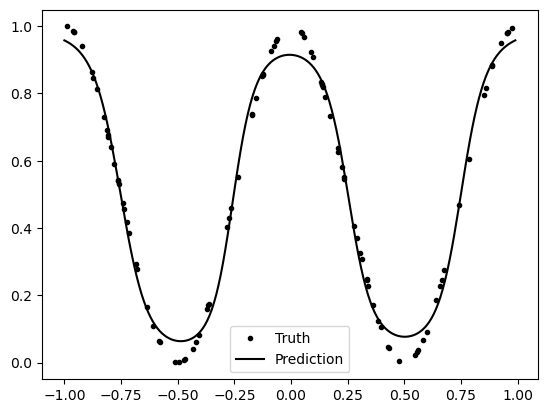

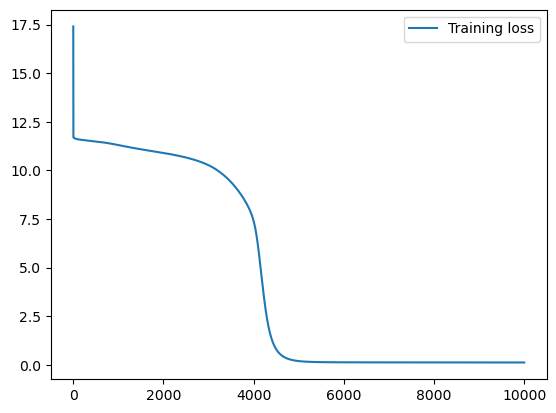

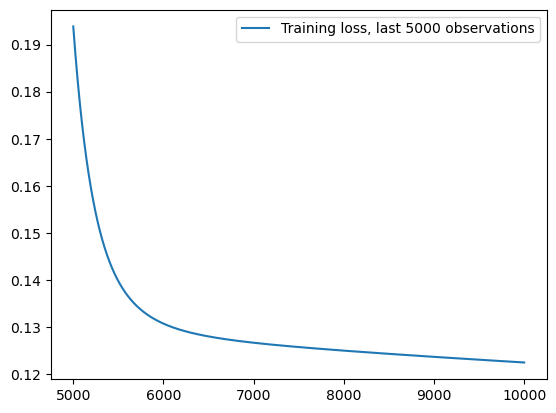

In [15]:
# Plot train samples, truth, test samples and predictions
plt.plot(x, y, 'k.', label="Truth")
plt.plot(x_pred, y_pred, 'k-', label="Prediction")
plt.legend()
plt.show()
plt.plot(range(n_iterations), network.loss, label="Training loss")
plt.legend()
plt.show()
plt.plot(range(int(n_iterations / 2), n_iterations),
         network.loss[int(n_iterations / 2):],
         label=f"Training loss, last {int(n_iterations / 2)} observations")
plt.legend()
plt.show()


We can improve performance by modifying the learning rate, the number of iterations, the number of layers/nodes per later and also implementing different types of activation and cost function. 
I  increased the value of the learning rate and the number of iterations by a factor of 10; after around 8000 iterations, the performance does not get that much better.

# Step 3: Fashion items classification

Let's test our model on a more sophisticated dataset, namely [Zalando research's fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This dataset includes 70,000 images of fashion items 28x28 pixels (=784), split into a training set of 60,000 images and a test set of 10,000 images. Each image is labeled with a digit from 0 to 9.  

The original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) consists in handwritten digits, e.g. to automatically read the addresses on mails. The performance of neural networks on this task was so much better than previous approaches that it (re-)sparked a lot of interest in them (and brought fame to Yann LeCun). It is now considered an "easy" task.

## Exercise 3: Get to know the dataset

1. Just run the following cell to download the Fashion MNIST database.

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

2. Next check that the shapes of the training and test data, and their content, are what you expect. Please answer by *e.g.* printing the shapes of the training and test data as well as the ranges of values that are contained in them and comment in the next cell. 

In [17]:
# YOUR CODE HERE
print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)
print(np.min(x_test), np.max(x_test))
print(np.min(y_test), np.max(y_test))

(60000,)
(60000, 28, 28)
(10000,)
(10000, 28, 28)
0 255
0 9


YOUR ANSWER HERE

The dataset has 60000 training vectors, 1000 testing vectors that are all of size 28*28. Each element of the array is an integer ranging from 0 to 255.

3. Get a feel for the dataset by displaying some images in _grayscale_. Please print one image per class together with their class label.

*Python hint*: [plt.imshow](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.imshow.html).

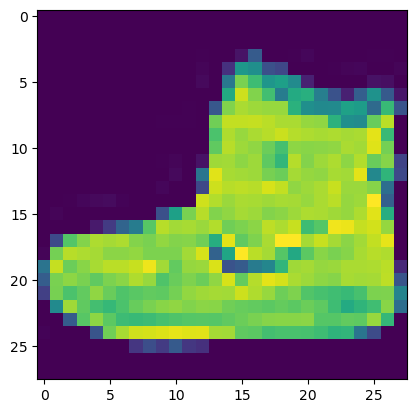

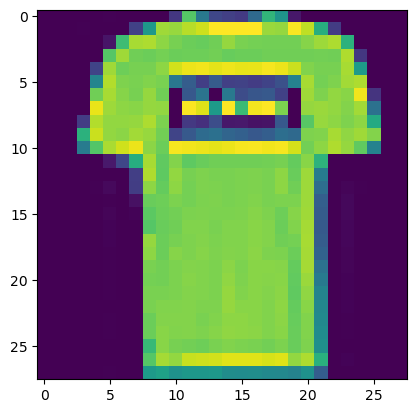

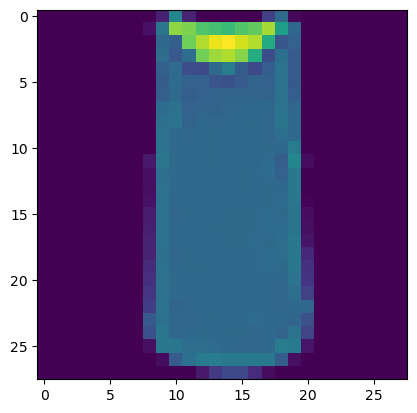

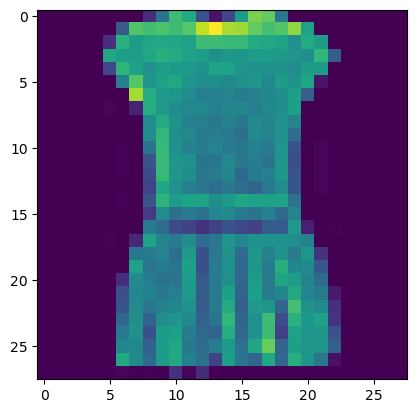

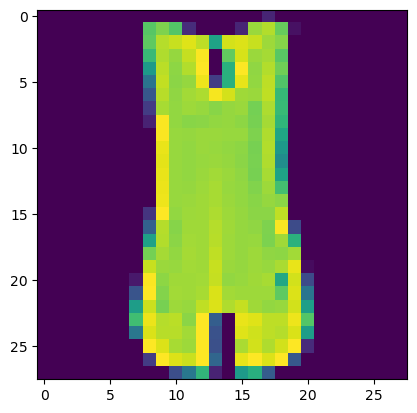

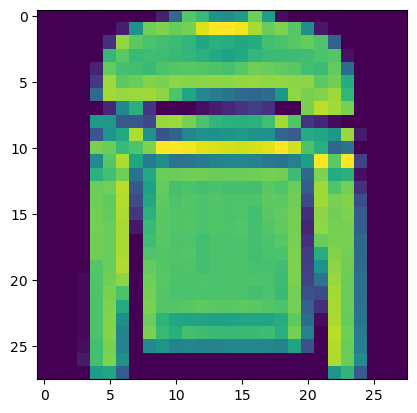

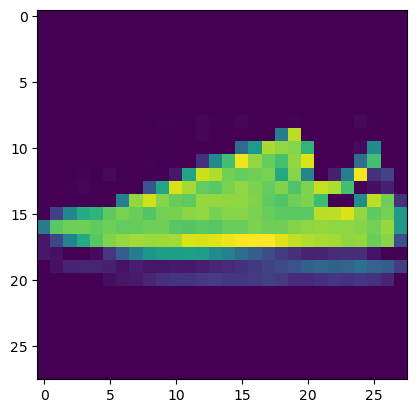

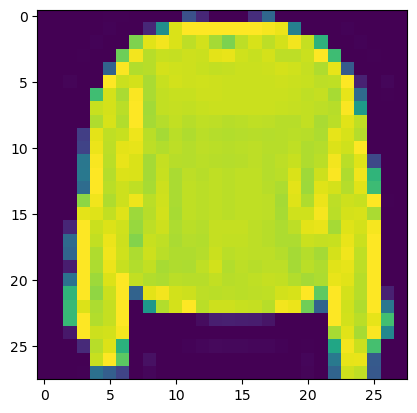

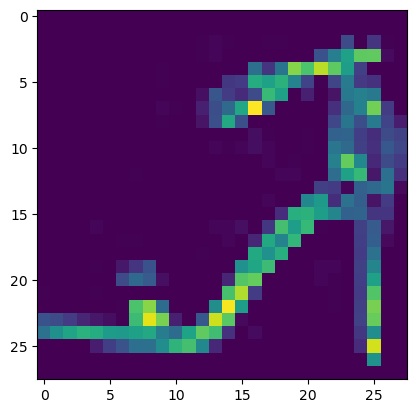

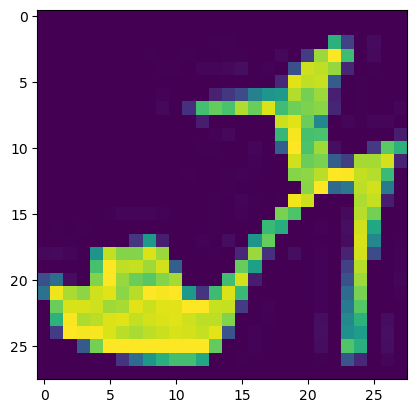

In [18]:
# YOUR CODE HERE
# raise NotImplementedError()
for i in range(10):
    plt.imshow(x_train[i])
    plt.show()

## Exercise 4: Create a one-hot encoding of the labels

`y_train` and `y_test` currently contain the digits 0-9, which is not suited for training as we want to perform a 10-class classification training on our network. To fix this, we need to perform a so-called one-hot encoding on the labels which convert each digit into a vector of length 10 full of zeros, except the element corresponding to the digit which should be 1.  For example, if our label is 3, then the corresponding one-hot encoding is [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

1. Convert the `y_train` and `y_test` vectors into one-hot encodings.

In [19]:
# y_train =  ...
# y_test =  ...
# YOUR CODE HERE
# raise NotImplementedError()
y_test_copy = y_test.copy()
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

## Exercise 5: Train your network to recognize fashion items

1. Implement the cross-entropy loss function below.

In [20]:
class CrossEntropy(Cost):
    """Cross Entropy loss function"""
    @staticmethod
    def __call__(y_pred: np.array, y: np.array) -> float:
        """
        Value of the cross entropy loss given predictions and true labels

        :param numpy.array y_pred: 1D array associated with the predicted probability of y=1
        :param numpy.array y: 1D array of true (0/1) classes
        :return: value of the loss
        :rtype: float or numpy.array
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        return np.sum(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred))


    @staticmethod
    def prime(y_pred: np.array, y: np.array) -> np.array:
        """
        Derivative of the cross entropy loss function

        :param numpy.array y_pred: 1D array associated with the predicted probability of y=1
        :param numpy.array y: 1D array of true (0/1) classes
        :return: gradient of the loss w.r.t. y_pred
        :rtype: numpy.array
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        return -(y/y_pred) + (1 - y) / (1 - y_pred)

In [21]:
assert CrossEntropy(np.array([0.5]), np.array([0])) == - np.log(0.5)
assert CrossEntropy.prime(np.array([0.5]), np.array([0])) == 2.0
assert int(CrossEntropy(np.array([0.5, 0.5]),
                    np.array([0, 1]))) == 1
assert CrossEntropy.prime(np.array([0.5]), np.array([0])) == 2.0

2. Instantiate a network with 1 hidden layer of 32 nodes, with sigmoid activations and a cross-entropy loss. Note that this network cannot take 2-dimensional data points as input. Therefore, it should be instantiated to expect 'flattened' images as input, i.e., images that have been converted to vectors.

In [22]:
# network = ...
# YOUR CODE HERE
# raise NotImplementedError()
network = Network([784, 32, 10], [Sigmoid, Sigmoid])


3. Train the network using the first 10000 images in the training set, any learning rate / number of epochs (see Exercise 4.4.). 

In [23]:
# Train the network for X epochs with a learning rate of Y
# Our implementation does not deal with 3D inputs, so you need
# to "flatten" the 28x28 images in a single vector / observation / sample / row.
# YOUR CODE HERE
# raise NotImplementedError()
network.train(x_train=x_train[:10000, :].reshape([10000, 784]),
              y_train=y_train[:10000, :],
              cost=QuadraticCost,
              learning_rate=0.15,
              epochs=120)

/tmp/ipykernel_296376/2029569746.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


epoch: 0 
	loss:  9999.999805677398
epoch: 1 
	loss:  9999.999805635869
epoch: 2 
	loss:  9999.999805594325
epoch: 3 
	loss:  9999.99980555276
epoch: 4 
	loss:  9999.99980551118
epoch: 5 
	loss:  9999.999805469577
epoch: 6 
	loss:  9999.99980542796
epoch: 7 
	loss:  9999.999805386324
epoch: 8 
	loss:  9999.99980534467
epoch: 9 
	loss:  9999.999805303001
epoch: 10 
	loss:  9999.999805261312
epoch: 11 
	loss:  9999.999805219608
epoch: 12 
	loss:  9999.99980517788
epoch: 13 
	loss:  9999.99980513614
epoch: 14 
	loss:  9999.99980509438
epoch: 15 
	loss:  9999.9998050526
epoch: 16 
	loss:  9999.999805010802
epoch: 17 
	loss:  9999.999804968988
epoch: 18 
	loss:  9999.999804927154
epoch: 19 
	loss:  9999.999804885309
epoch: 20 
	loss:  9999.999804843439
epoch: 21 
	loss:  9999.999804801553
epoch: 22 
	loss:  9999.99980475965
epoch: 23 
	loss:  9999.999804717727
epoch: 24 
	loss:  9999.999804675786
epoch: 25 
	loss:  9999.99980463383
epoch: 26 
	loss:  9999.999804591855
epoch: 27 
	loss:  999

4. Plot the evolution of the loss and go back to training, tweaking the learning rate / number of iterations until the plot looks satisfactory.

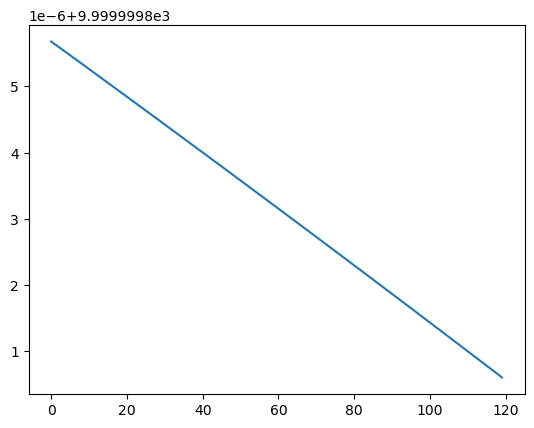

In [24]:
# YOUR CODE HERE
# raise NotImplementedError()

plt.plot(network.loss)
plt.show()

3. Compute the accuracy of the model (and put it in `accuracy`) on the test data and compare a few predictions to their images in grayscale (see labels [here](https://github.com/zalandoresearch/fashion-mnist#labels)).

/tmp/ipykernel_296376/2029569746.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


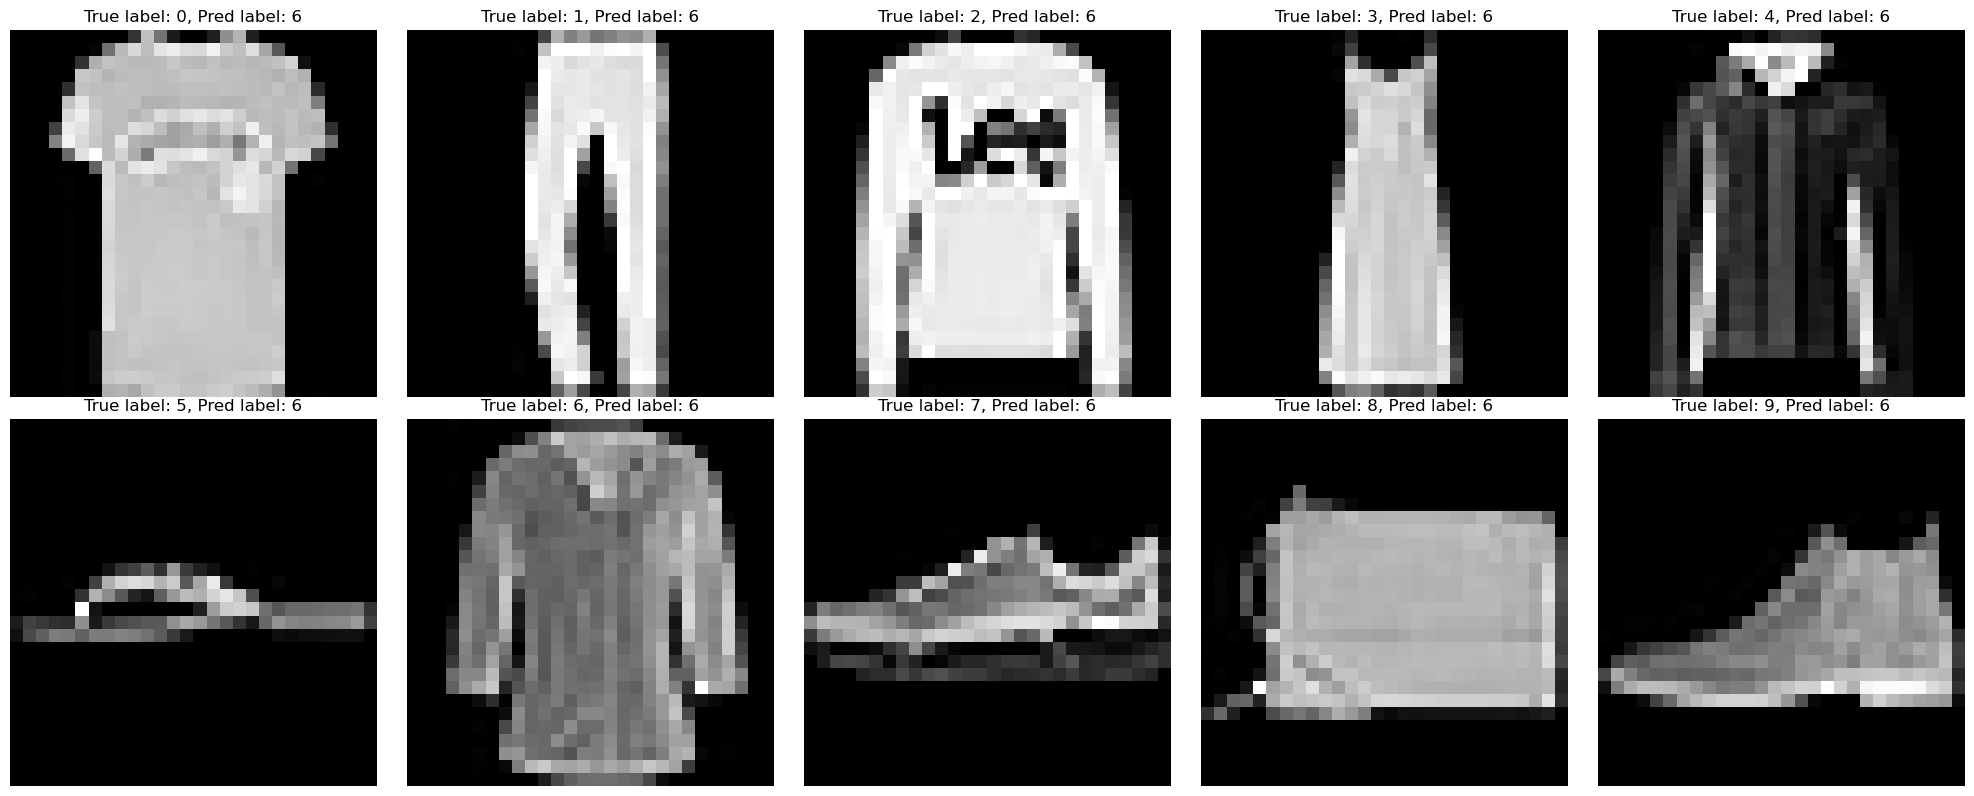

In [25]:
# Compute the accuracy
# accuracy = ...

# For example, display an example of a class probability and its true value
# YOUR CODE HERE
#raise NotImplementedError()
y_pred, _, _ = network.feed_forward(x_test.reshape([10000, 784]))
accuracy = np.logical_and(y_test.astype(int),(y_pred == y_pred.max(axis=1)[:,None]).astype(int)).sum()/len(y_test)

labels = [label for label in range(y_test_copy.min(), y_test_copy.max() + 1)]
n_rows = 2  
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))  # Adjust figsize as needed
axes = axes.flatten()

for i, label in enumerate(labels):
    index = np.where(y_test_copy == label)[0][0]
    ax = axes[i]
    ax.imshow(x_test[index], cmap = 'gray')
    pred_label, _, _ = network.feed_forward(x_test[index].reshape(1, 784))
    pred_label = np.argmax(pred_label)
    ax.set_title(f"True label: {label}, Pred label: {pred_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exercise 6: Multiple choice quiz testing your understanding of core concepts

Please fill in the dictionary in the next code cell with the correct answers to the below questions. Please note that each question only has one correct answer and that the answers entered into the dictionary should in captial letters and of string type. 

**Question 1**:
This is an example question to illustrate the answer format.

A) Wrong Answer. 

B) Right Answer.

**Question 2**:
In which learning task is the cross-entropy loss most suitable?

A) Regression. 

B) Classification.

**Question 3**:
In which learning task is the quadratic loss most suitable?

A) Regression. 

B) Classification.

**Question 4**:
In the backpropagation algorithm used to train neural networks, which gradients do we use to update the neural network parameters?

A) the gradient of the loss with respect to the input. 

B) the gradient of the loss with respect to the true labels. 

C) the gradient of the loss with respect to the parameters. 

**Question 5**:
True or False: "In the update step function implementing Gradient Descent the gradients corresponding to the different datapoints are averaged".

A) This statement is true. 

B) This statement is false.

**Question 6**:
Does the loss of a neural network decrease at every epoch throughout training for all datasets and learning tasks?

A) No, the loss can increase for certain epochs. 

B) Yes, the loss is always strictly decreasing throughout training.

**Question 7**:
If a neural network takes inputs of dimension 784 and the first hidden layer is composed of 64 neurons (using the notation $\sigma(xW+b)$, where $x \in \mathbb{R}^{1 \times 784}$ is the input). What are the dimensions of the weight matrix $W$ and the bias vector $b$?

A) $W\in \mathbb{R}^{784 \times 64}$ and $b\in \mathbb{R}^{784}$. 

B) $W\in \mathbb{R}^{50176 \times 64}$ and $b\in \mathbb{R}^{64}$. 

C) $W\in \mathbb{R}^{64 \times 784}$ and $b\in \mathbb{R}^{784}$. 

D) $W\in \mathbb{R}^{784 \times 64}$ and $b\in \mathbb{R}^{64}$. 

**Question 8**:
What is the total number of parameters (including weight matrices and bias vectors) of a neural network, that takes 2 dimensional inputs, contains one single hidden layer of dimension 32 and gives 1 dimensional outputs?

A) 99. 

B) 129.

C) 161.

D) 225.


In [26]:
# YOUR CODE HERE
# raise NotImplementedError()

# Uncomment the following dictionary and put your answers
 answers= {
     "q1": "B",
     "q2": "B",
     "q3": "A",
     "q4": "C",
     "q5": "A",
     "q6": "A",
     "q7": "D",
     "q8": "B",    
 }

# Extra

You now have a fully functioning neural network model which can be used in real machine-learning problems.  There are many things which you could add at this point to make the model more effective.  Consider playing with some of the following:

- Adding weight regularization
- Using different activation functions such as ReLU or Tanh
- Improve the efficiency by making the backprop algorithm work on whole batches at once
- Implement the SGD algorithm
- Redesign the model to allow plug-and-play layers to be stacked together, allowing more complicated layers such as convolutions to be used.

Of course the list is endless, just have fun!

## Next Step: Using Tensorflow

As you have now seen, building a neural network and training from scratch can require a significant amount of effort.  Furthermore, the naive design of our `Network` class does not allow us to easily incorporate new kinds of layers such as convolutions, dropout, or batch normalization.  In practice of course, several libraries already exist that provide all of this functionality for you, so that you can focus on building a model for your specific dataset.  Here, we will show you how to redo the fashion classification example above, with less than 10 lines of code using the Tensorflow library. You can [find this example](https://www.tensorflow.org/tutorials) directly on the Tensorflow website if you are interested.  Let's walk through the code below.

### Import Tensorflow and download the MNIST dataset

Tensorflow includes a high-level neural network architecture building API called Keras which makes it easy to create neural network models using "off-the-shelf" layers.  In addition, Keras also provides commonly used datasets, such as the MNIST dataset.  

### Build the NN model

In the next two cells, the Keras API is used to create a simple NN model with the following layers:

- `Flatten` takes an N-dimensional array and reshapes it into a 1D array. In this case, the images are 28x28 pixels, which get converted to a 784 1D tensor.
- `Dense` is exactly like the type of implicit layers we coded in our `Network` class.  That is, they take some 1D input and apply a linear transformation before applying a nonlinear activation.  In this case we are using 512 nodes in the dense layer.
- `Dropout` is a little more advanced.  As you have seen in the lecture, a dropout layer sets some percentage of the inputs to the layer to zero.  During training, each time data is propagated through the dropout layer, a different random set of nodes is zeroed out.  This forces the network to make more generalizations about the data and reduces overfitting.  When training is done, the dropout layer allows all the nodes to pass through, but multiplies the result by the dropout factor such that the sum remains the same.  In this case, 20% of the nodes are randomly canceled out during training and the result during evaluation is multiplied by 0.8.  
- The final layer is a dense layer of 10 nodes corresponding to the one-hot encoding of the digit labels.  Note that a softmax activation function is used so that these nodes will represent probabilities.

In the second cell, the model is "compiled" with an optimizer (Adam), loss function (sparse categorical crossentropy), and a metric, which is responsible for providing useful output during training.  In this case, the `accuracy` metric is used which computes the total number of training samples that were correctly categorized as training progresses.

You may modify the model as you wish.

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

2024-04-10 23:36:36.004109: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 23:36:36.019822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 23:36:36.019971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train and evaluate the model

In the last step, we train the model.  This happens in the first line below, were we call the model's `fit` function, which takes the training data and a number of epochs.  The number of batches per epoch is handled by default.  In the second line, we evaluate the model on our testing data to see how well it does on data it has never seen before.  Note that we get a ~ 79% accuracy with this simple model!

In [29]:
n_epoch = 5

In [30]:
model.fit(x_train, y_train, epochs=n_epoch)
loss, acc = model.evaluate(x_test, y_test)
print("Final test loss:", loss)
print("Final test accuracy:", acc)

Epoch 1/5


2024-04-10 23:36:37.079469: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f071a26ea40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 23:36:37.079488: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2024-04-10 23:36:37.083274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 23:36:37.094707: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1712784997.160642  296458 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 3s 1ms/step - loss: 3.1517 - accuracy: 0.6978
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7327 - accuracy: 0.7358
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6982 - accuracy: 0.7482
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7030 - accuracy: 0.7441
Epoch 5/5
313/313 [==============================] - 0s 872us/step - loss: 0.5801 - accuracy: 0.7907
Final test loss: 0.5800907015800476
Final test accuracy: 0.7907000184059143


313/313 [==============================] - 0s 616us/step
The probabilities for each class for the first test point:
 [[5.7570550e-12]
 [6.6157182e-09]
 [6.0867002e-18]
 [3.8990808e-13]
 [8.3682461e-22]
 [2.2686897e-02]
 [3.1717926e-17]
 [8.3465248e-02]
 [7.1184707e-12]
 [8.9384782e-01]]
The true class of the first test point:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


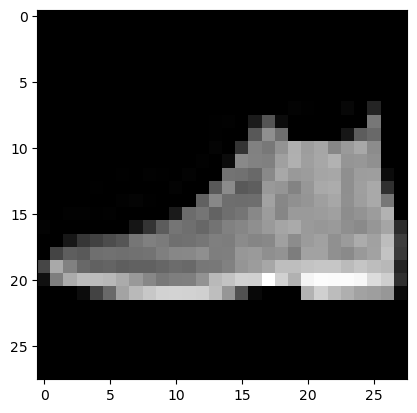

In [31]:
print("The probabilities for each class for the first test point:\n", model.predict(x_test)[0, :].reshape(-1, 1))
print("The true class of the first test point:\n", y_test[0].reshape(-1, 1))
plt.imshow(x_test[0, :], cmap='gray');

Let's do the same with PyTorch. There are many deep learning frameworks, but Tensorflow and PyTorch are the most used, with Tensorflow becoming out-of-fashion (!) in favor of PyTorch, generally dubbed "simpler" (well, we'll see how that turns out!).

(Tensorflow is indeed more complicated but in the code above, we relied on Keras, a library built on top and meant to simplify the usage of several deep learning frameworks.)

In [32]:
from torch import nn, optim, no_grad
from torch import float as torch_float
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

Re-download and/or unzip the MNIST dataset with the torch API / format with the following commands.

In [33]:
%%bash
mkdir -p $HOME/.keras/datasets/FashionMNIST
ln -s -f $HOME/.keras/datasets/fashion-mnist $HOME/.keras/datasets/FashionMNIST/raw

In [34]:
training_data = datasets.FashionMNIST(
    root="~/.keras/datasets",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="~/.keras/datasets",
    train=False,
    download=True,
    transform=ToTensor(),
)

Create data loaders (iterators over the training and testing data, think `range`).

In [35]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Create the model as a class inheriting from nn.Module.
You must at least define `__init__`, where you might want to define the structure of your network, as well as the `forward` method (which is basically `feed_forward`).

In [36]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Instantiate your model by instantiating an object of this new class. You still need a loss function (our `Cost`), and an optimizer (we hard-coded Gradient Descent in `Network`).

Then we iterate on the training data for a given number of epochs, using a `for` loop. At each iteration, we must:
* Perform the feedforward pass;
* Compute the loss ($\delta^L$);
* Perform backpropagation by:
    * Calculating the loss and the gradients of $W$ and $b$ for $l < L$;
    * Update the parameters $W$ and $b$.

In [37]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-07)
model.train()  # Switch to training mode

for _ in range(n_epoch):
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

To compute the testing loss / error, we use the iterator over the test dataset and the loss function, which we previously defined.

In [38]:
model.eval()  # Switch to evaluation mode
test_loss, correct = 0, 0
# Do not compute the gradient
with no_grad():
    for X, y in test_dataloader:
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch_float).sum().item()
test_loss /= len(test_dataloader.dataset)
correct /= len(test_dataloader.dataset)
print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 77.2%, Avg loss: 0.009133 



## Your turn (Bonus)
Play with tensorflow / keras and / or pytorch and provide your own model and training routine.

Try to separate the data into train / dev / test where train is used to train the model, dev is used to evaluate the model's performance at each epoch, and test is hold out until the end of the training.

You may want to test on other datasets. See [keras datasets](https://keras.io/api/datasets/) and [PyTorch datasets](https://pytorch.org/vision/stable/datasets.html).

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

dev_images = test_images[:5000]
dev_labels = test_labels[:5000]
test_images = test_images[5000:]
test_labels = test_labels[5000:]

train_images = train_images / 255.0
dev_images = dev_images / 255.0
test_images = test_images / 255.0

train_labels = to_categorical(train_labels)
dev_labels = to_categorical(dev_labels)
test_labels = to_categorical(test_labels)

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_data=(dev_images, dev_labels))

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_accuracy)


Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2557 - accuracy: 0.9267 - val_loss: 0.1754 - val_accuracy: 0.9438
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1116 - accuracy: 0.9668 - val_loss: 0.1459 - val_accuracy: 0.9552
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0756 - accuracy: 0.9775 - val_loss: 0.1147 - val_accuracy: 0.9616
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0558 - accuracy: 0.9828 - val_loss: 0.1057 - val_accuracy: 0.9666
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0438 - accuracy: 0.9869 - val_loss: 0.1078 - val_accuracy: 0.9654
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.0992 - val_accuracy: 0.9720
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0961 - val_accuracy: